In [29]:
# pip install gymnasium
# pip install torch

import pandas as pd
import numpy as np
import random
import gymnasium as gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. First steps

We will start by gaining intuition on the task at hand by running a random agent. Create a
RandomAgent, which selects actions randomly. 

In [126]:
class RandomAgent:
        
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transistion of the environment"""
        pass
    
    def select_action(self, state):
        """"Pick an action from the given state"""
        return env.action_space.sample()
    
    def update(self):
        """"Called after each environment step. 
        This is where all the training takes place"""
        pass

Run the agent on the environment until the episode is
either truncated or terminated. Store the episode and render (visualize) it.

In [128]:
env = gym.make('MountainCar-v0', render_mode='human')

agent = RandomAgent()

done = False
state, _ = env.reset()
episode_reward = 0

states = []
actions = []
rewards = []

while not done:
    env.render()
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += reward
    states.append(state)
    actions.append(action)
    rewards.append(reward)

    state = next_state
    done = terminated or truncated

env.close() 

Now run the agent for 100 episodes. At every episode initialize the environment with a new randomly
sampled seed. Plot the duration of each episode as a scatter plot. What do you find? Explain.

In [32]:
env = gym.make('MountainCar-v0')

agent = RandomAgent()
episode_durations = []
n_episodes = 100
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_length = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        state = next_state
        episode_length += 1
        done = terminated or truncated

    episode_durations.append(episode_length)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 357.15it/s]


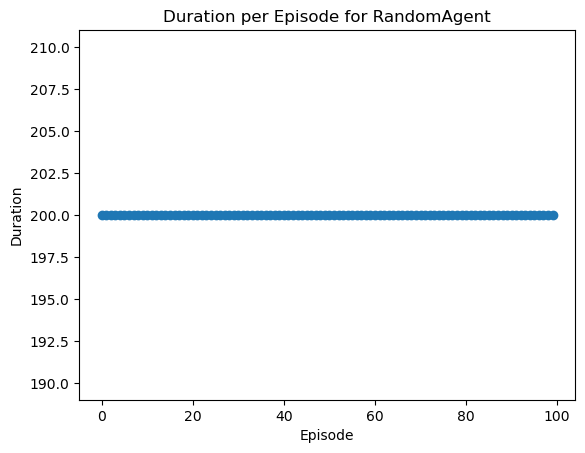

In [33]:
plt.scatter(range(n_episodes), episode_durations)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Duration per Episode for RandomAgent')
plt.show()

We find that by taking random actions, the car is never lucky and cannot finish even a single episode. 

# 3. DQN

## 3.1 Implementation
Create a `DQNAgent` class that implements a DQN agent that uses a feed-forward network to estimate
Q-values and an eps-greedy policy to take actions. Since DQN is an off-policy RL algorithm, make sure
your class has a replay buffer that allows to add observed transitions `(s,a,r,s′)` and sample batches of
transitions for the network updates

In [34]:
class DQNAgent:

    def __init__(self, env):
        self.env = env
        self.Q = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
        self.gamma = 0.99
        self.t = 0
        self.epsilon = 0.9
        self.replay_buffer = deque(maxlen=10000) # Using deque for efficient removal of old experiences
        self.batch_size = 64
        self.optimizer = torch.optim.Adam(
            self.Q.parameters(),
            lr = 0.001
        )
    
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transition of the environment"""
        self.replay_buffer.append((state, action, next_state, reward))
    
    def select_action(self, state):
        """" Pick an action from the given state """
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension
        Q_values = self.Q(state_tensor)
        action = self.epsilon_greedy(Q_values)
        return action.item()  # Return as Python int
    
    def update(self): # chatGPT
        if len(self.replay_buffer) < self.batch_size:
            return 0 # Not enough samples
        
        transitions_minibatch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, next_states, rewards = zip(*transitions_minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        rewards = torch.tensor(rewards, dtype=torch.float32)

        current_qs = self.Q(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_qs = self.Q(next_states).max(1)[0].detach()
        targets = rewards + self.gamma * next_qs

        loss = F.mse_loss(current_qs, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    def epsilon_greedy(self, Q_val):
        """ Chooses an epsilon-greedy action starting from a given state and given Q-values """
        # a = -1/1000 * ln(0.05/0.9) = 0.00289, 0.0015 for 2000
        if self.epsilon > 0.05:
            self.epsilon = 0.9 * np.exp(-0.0018 * self.t)
        self.t += 1 
        if np.random.uniform(0, 1) < self.epsilon:
            # with probability epsilon make a random move (exploration)
            return torch.tensor(self.env.action_space.sample()) # env.action_space.sample() 
        else:
            # with probability 1-epsilon choose the action with the highest immediate reward (exploitation)
            return torch.argmax(Q_val) 

Train the DQNAgent for 1000 episodes and report its loss and average cumulative reward per episode.
Does your agent solve the task?

In [35]:
env = gym.make('MountainCar-v0')

agent_DQN = DQNAgent(env)
episode_durations = []
episode_rewards = []
episode_losses = []
n_episodes = 1000
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_reward = 0
    episode_length = 0
    episode_loss = 0
    
    while not done:
        action = agent_DQN.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        agent_DQN.observe(state, action, next_state, reward)

        loss = agent_DQN.update()
        state = next_state
        episode_length += 1
        episode_loss += loss 
        episode_reward += reward
        done = terminated or truncated

    episode_durations.append(episode_length)
    episode_rewards.append(episode_reward)
    episode_losses.append(episode_loss)

100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


In [36]:
print(f"The average cumulative reward per episode is {sum(episode_rewards)/n_episodes}")

The average cumulative reward per episode is -200.0


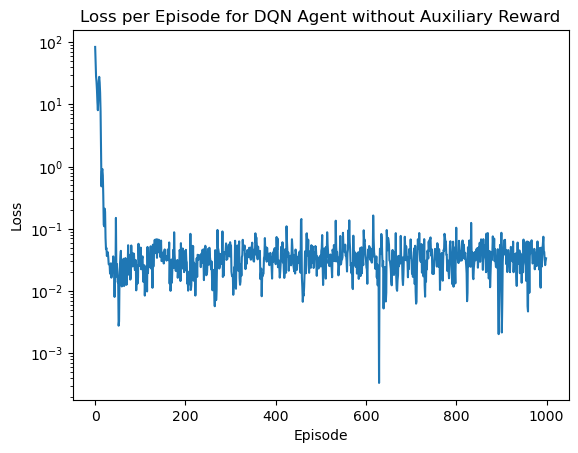

In [37]:
episode_losses_array = [x.detach().numpy() for x in episode_losses]
plt.plot(range(n_episodes), episode_losses_array)
plt.yscale("log")
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss per Episode for DQN Agent without Auxiliary Reward')
plt.show()

In [38]:
env = gym.make('MountainCar-v0', render_mode='human')

done = False
state, _ = env.reset()

while not done:
    env.render()
    action = agent_DQN.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    # agent_DQN.observe(state, action, next_state, reward)

    # agent_DQN.update()
    state = next_state
    done = terminated or truncated

env.close() 

No, the agent does not solve the task. However, we see that the actions are not random anymore: the agent mostly want to accelerate to the right. 

## 3.3 Heuristic reward function

In [147]:
def heuristic_reward(next_state, terminated, episode_length): 
    if terminated: 
        return 1+2*(200-episode_length)/200 # favorize short episode 
    aux_reward = reward + np.power(next_state[0]- (-0.5), 2) 
    return aux_reward

In [148]:
env = gym.make('MountainCar-v0')

agent_DQN_with_AR = DQNAgent(env)
episode_durations = []
episode_rewards = []
episode_aux_rewards = []
episode_losses = []
success_track = []
n_episodes = 3000
for n in tqdm(range(n_episodes)):

    done = False
    state, _ = env.reset()
    episode_reward = 0
    episode_aux_reward = 0
    episode_length = 0
    episode_loss = 0
    
    while not done:
        action = agent_DQN_with_AR.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        aux_reward = heuristic_reward(next_state, terminated, episode_length)
        agent_DQN_with_AR.observe(state, action, next_state, reward + aux_reward)

        loss = agent_DQN_with_AR.update()
        state = next_state
        episode_length += 1
        episode_loss += loss 
        episode_reward += reward
        episode_aux_reward += aux_reward

        done = terminated or truncated

    success_track.append(1 if terminated else 0)
    episode_durations.append(episode_length)
    episode_rewards.append(episode_reward)
    episode_aux_rewards.append(episode_aux_reward)
    episode_losses.append(episode_loss)

episode_tot_rewards = [x + y for x, y in zip(episode_rewards, episode_aux_rewards)] 

100%|██████████| 3000/3000 [19:41<00:00,  2.54it/s]


In [154]:
env = gym.make('MountainCar-v0', render_mode='human')

done = False
state, _ = env.reset()

while not done:
    env.render()
    action = agent_DQN_with_AR.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    # agent_DQN_with_AR.observe(state, action, next_state, reward)

    # agent_DQN_with_AR.update()
    state = next_state
    done = terminated or truncated

env.close() 

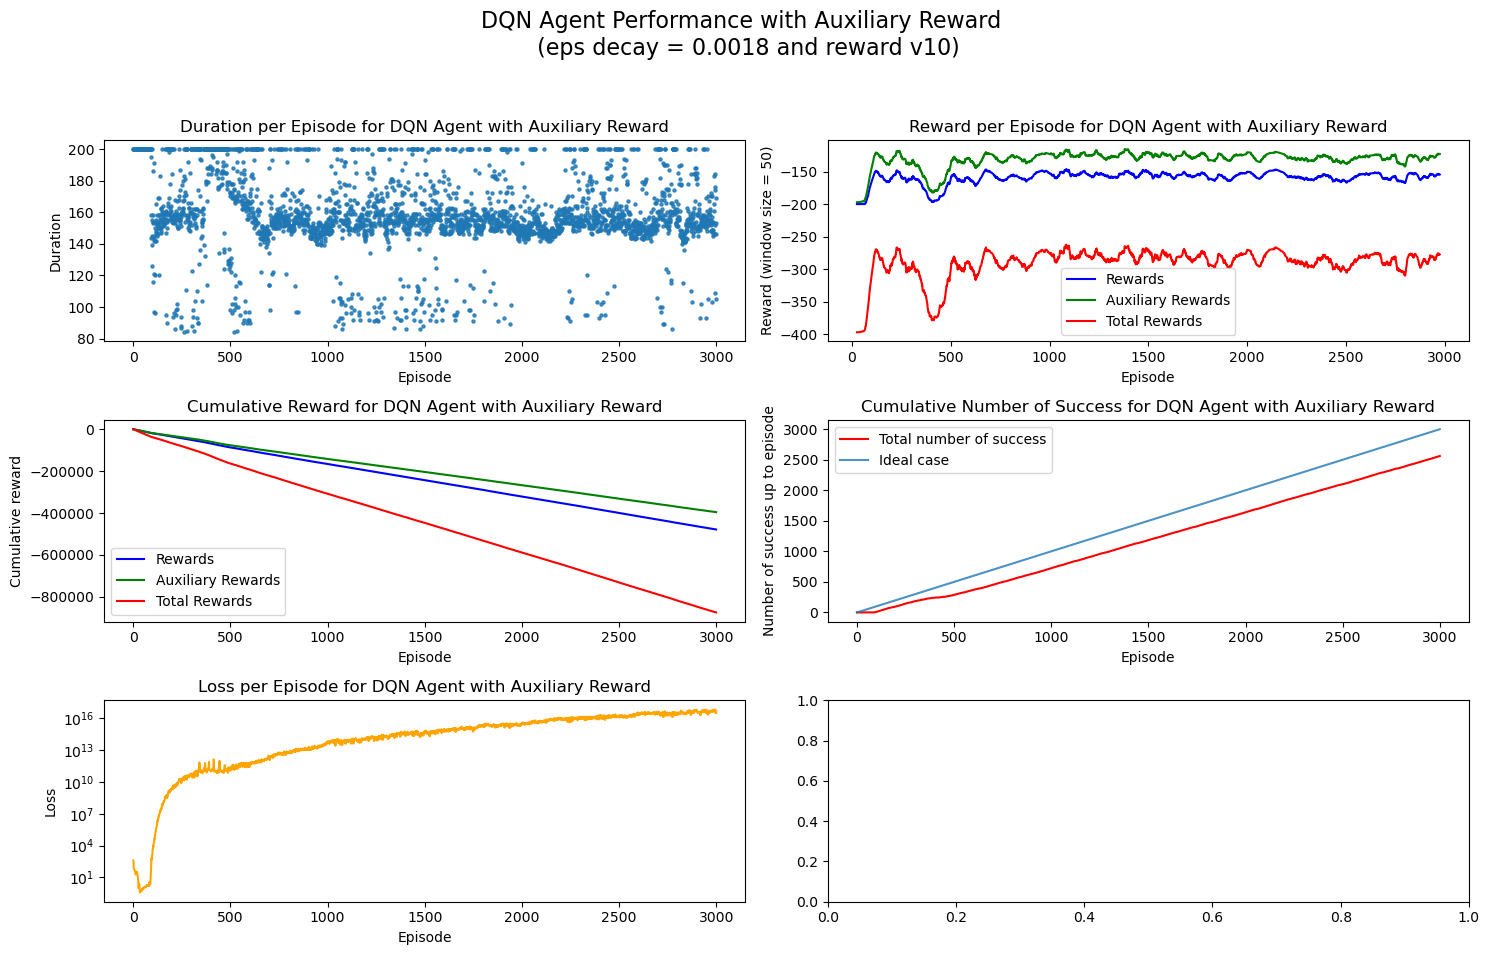

In [150]:
def avg_list(lst):
    list_serie = pd.Series(lst)
    return list_serie.rolling(window=50, center=True).mean()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))  # Adjust the figure size as needed

# Episode duration
axes[0, 0].scatter(range(n_episodes), episode_durations, alpha=0.8, s=5)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Duration')
axes[0, 0].set_title('Duration per Episode for DQN Agent with Auxiliary Reward')

# Reward
axes[0, 1].plot(avg_list(episode_rewards), color='blue', label='Rewards')
axes[0, 1].plot(avg_list(episode_aux_rewards), color='green', label='Auxiliary Rewards')
axes[0, 1].plot(avg_list(episode_tot_rewards), color='red', label='Total Rewards')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Reward (window size = 50)')
axes[0, 1].set_title('Reward per Episode for DQN Agent with Auxiliary Reward')
axes[0, 1].legend()

# Cumulative reward
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_rewards), color='blue', label='Rewards')
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_aux_rewards), color='green', label='Auxiliary Rewards')
axes[1, 0].plot(range(n_episodes), np.cumsum(episode_tot_rewards), color='red', label='Total Rewards')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Cumulative reward')
axes[1, 0].set_title('Cumulative Reward for DQN Agent with Auxiliary Reward')
axes[1, 0].legend()

# Cumulative number of success
axes[1, 1].plot(range(n_episodes), np.cumsum(success_track), color='red', label='Total number of success')
axes[1, 1].plot(range(n_episodes), range(n_episodes), alpha=0.8, label = 'Ideal case')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Number of success up to episode')
axes[1, 1].set_title('Cumulative Number of Success for DQN Agent with Auxiliary Reward')
axes[1, 1].legend()

# Training loss
episode_losses_array = [x.detach().numpy() for x in episode_losses]
axes[2, 0].plot(range(n_episodes), episode_losses_array, color='orange')
axes[2, 0].set_yscale("log")
axes[2, 0].set_xlabel('Episode')
axes[2, 0].set_ylabel('Loss')
axes[2, 0].set_title('Loss per Episode for DQN Agent with Auxiliary Reward')

fig.suptitle('DQN Agent Performance with Auxiliary Reward \n (eps decay = 0.0018 and reward v10)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
plt.show()

# Tests

## 3.1

In [ ]:
class DQNAgent:

    def __init__(self, eps = 0.1):
        self.env = env
        self.Q = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
        )
        self.gamma = 0.99
        self.epsilon = eps
        self.replay_buffer = np.empty(10000)
        self.batch_size = 64
        self.optimizer = torch.optim.Adam(
            self.Q.parameters(),
            lr = 0.001
        )
        self.t = 0
    
    def observe(self, state, action, next_state, reward):
        """Called upon observing a new transition of the environment"""
        transition = (state, action, next_state, reward)
        self.replay_buffer = np.insert(self.replay_buffer, 0, transition) # new trans at the beginning of R
        if len(self.replay_buffer) > 10000:
            self.replay_buffer = self.replay_buffer[:10000]
    
    def select_action(self, state):
        """" Pick an action from the given state """
        state_tensor = torch.from_numpy(state)
        Q_values = self.Q(state_tensor)
        action = self.epsilon_greedy(Q_values)
        return action
    
    def update(self):
        """" Called after each environment step. 
        This is where all the training takes place """
        
        transitions_minibtach = np.random.choice(self.replay_buffer, self.batch_size, replace=False)

        loss = self.compute_loss(transitions_minibtach)
        loss.backward()  # Compute gradients
        self.optimizer.step()
        self.t += 1

    def compute_loss(self, transitions_minibtach):
        loss = 0
        for transition in transitions_minibtach:
            s, a, r, s2 = transition
            loss += (r + self.gamma * torch.max(self.Q(s2)) - self.Q(s))**2
        return loss

    def epsilon_greedy(self, Q_val):
        """ Chooses an epsilon-greedy action starting from a given state and given Q-values """
        if np.random.uniform(0, 1) < self.epsilon:
            # with probability epsilon make a random move (exploration)
            return env.action_space.sample()
        else:
            # with probability 1-epsilon choose the action with the highest immediate reward (exploitation)
            return torch.argmax(Q_val)

In [ ]:
# def heuristic_reward(next_state, reward, terminated): # v1
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 0 
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) # + np.abs(next_state[1]) # + next_state[1] # + np.max(0, next_state[1])
#     return aux_reward

# def heuristic_reward(next_state, reward, terminated): # v2
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 1
#     # if truncated: # -1 if truncated and does not had goal? : peur de niquer nos efforts
#     #     return -1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + np.abs(next_state[1]) # avantage les vitesses positives
    # return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v3
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 1
#     aux_reward = np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1]) # avantage les vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v4
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[0]) + max(0, next_state[1]) # avantage les positions et vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v5
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated and episode_length<110: 
#         return 4
#     if terminated: 
#         return 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1]) # avantage les positions et vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v6
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + abs(next_state[1]) # avantage les positions et vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v7
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     if next_state[0]<-1 or next_state[0]>0.3: 
#         return 1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1])  # avantage les vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v8
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 2
#     if next_state[0]<-1.1 or next_state[0]>0.4: 
#         return 1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) + max(0, next_state[1])  # avantage les vitesses positives
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v9
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated and episode_length<90: 
#         return 2
#     if terminated: 
#         return 1
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) 
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v10
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated and episode_length<90: 
#         return 1+2*(200-episode_length)/200 # favorize short episode with factor of 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) 
#     return aux_reward

# def heuristic_reward(next_state, terminated, episode_length): # v11 => resultat nul...
#     # pas de reward sur la vitesse, reward quadratique avec la distance de la position initiale
#     if terminated: 
#         return 1+2*(200-episode_length)/200 # favorize short episode with factor of 2
#     aux_reward = reward + np.power(next_state[0]- (-0.5), 2) - episode_length/200
#     return aux_reward

Num
Observation
Min
Max
Unit

0
position of the car along the x-axis
-1.2
0.6
position (m)

1
velocity of the car
-0.07
0.07
velocity (v)

Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)

The position of the car is assigned a uniform random value in [-0.6 , -0.4]. 

The starting velocity of the car is always assigned to 0.